In [226]:
from scipy.special import kl_div, rel_entr
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon 
from scipy.stats import kstest 
from scipy.stats import wasserstein_distance
from scipy.stats import rv_histogram 
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import collections
import scipy.stats as stat
from scipy.stats import iqr 

from sklearn.neighbors import KernelDensity

from IPython.display import display

In [672]:
device = 'cpu'
gen_dir = 'generated_data/'
models_dir = 'models/' 
results_dir = 'results/'

In [3]:
# Load data
data = np.load('master_data/data.npy')
train_batches = data.shape[0] # N hereafter. Number of training images in database.
length = data.shape[1] 
stocks = data.shape[2]
print('Number of training batches: ', train_batches)
print('Length of each batch: ', length)
print('Number of stocks: ', stocks)

Number of training batches:  79
Length of each batch:  256
Number of stocks:  434


In [4]:
vaeconv1 = np.load(gen_dir + 'vaeconv1.npy')
vaeconv3 = np.load(gen_dir + 'vaeconv3.npy')
vaefd1 = np.load(gen_dir + 'vaefd1.npy')
vaefd2 = np.load(gen_dir + 'vaefd2.npy')
vqvaeconv2 = np.load(gen_dir + 'vqvaeconv2.npy')
vqvaefd1 = np.load(gen_dir + 'vqvaefd1.npy')


In [29]:
generated = {
            'VQ VAE CONV2':vqvaeconv2,
            'VAE CONV1 ':vaeconv1,
             'VAE CONV3':vaeconv3,
             'VAE FD1':vaefd1,
             'VAE FD2':vaefd2,
             'VQ VAE FD1':vqvaefd1
             }

In [6]:
# Random batches
index = np.random.randint(0, train_batches, 4)
index = [38, 25, 56, 24]

In [28]:
data_eval = np.zeros((len(index), data.shape[2], data.shape[1]))
# print(data_eval.shape)
for i in range(len(index)):
    # print(i)
    batch = data[index[i], :, :].copy()
    batch = np.transpose(batch)
    data_eval[i] = batch
data_eval.shape

(4, 434, 256)

In [8]:
def plot_density(real, synth):
    real = pd.DataFrame(real)
    real['label'] = 'Real distribution'
    real.columns = ['value', 'label']
    synth =synth.flatten()
    synth = pd.DataFrame(synth)
    synth['label'] = 'Synthetic distribution'
    synth.columns = ['value', 'label']
    df = pd.concat([real, synth])
    g =sns.histplot(df,
    bins='auto',
    kde=True,
    x = 'value',
    hue='label',
    stat="density",
    # facet_kws={'legend_out': False}, 
    alpha=0.3,
    common_bins=False,
    # ax=axes[i//2, i%2]
            )
    g.set(xlabel= None, ylabel= None )
    g.legend_.set_title(None)
    plt.show()

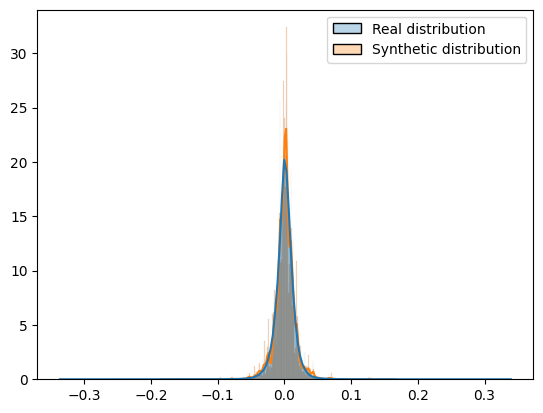

In [40]:
i = 0
real = data_eval[i].flatten()
synth =vqvaeconv2.flatten()
plot_density(real, synth)

In [33]:

def reject_outliers(data, m = 2., verbose = False):
    """
    Reject outliers based on median absolute deviation
    """
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    data_clean = data[s<m]
    if verbose:
        print('Reject outliers: %.2f%%' % ((data.shape[0]- data_clean.shape[0])/data.shape[0]*100))
        print('Max before: %.2f, Max now: %.2f' % (np.max(data), np.max(data_clean)))
        print('Min before: %.2f, Min now: %.2f' % (np.min(data), np.min(data_clean)))
    return data_clean

In [663]:
def histogram_pdf(array,sample=1000, w=None, bins='auto', density=True):
    #Get histogram
    hist, bin_edges =  np.histogram(array, bins=bins, density=density)
    if w:
        print('Adding prior correction to histogram')
        histogram_dist = rv_histogram((
            np.histogram(array, bins=bins, density=density)[0] + w * np.ones(len(hist)),
            bin_edges)
            ,density=density)
    else:
        histogram_dist = rv_histogram((hist, bin_edges),density=density)

    #Generate arrays of pdf evaluations
    X = np.linspace(np.min(array), np.max(array), sample)
    rvs_array = [histogram_dist.pdf(x) for x in X]
    pdf = rvs_array/sum(rvs_array)
    return pdf

def kernel_pdf(array, sample):
    #Get kernel density
    bandwidth = 1.06 * array.std() * array.size ** (-1 / 5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(array.reshape(-1, 1))
    #Generate arrays of pdf evaluations
    X = np.linspace(np.min(array), np.max(array), sample)
    probabilities = np.exp(kernel.score_samples(X.reshape(-1, 1)))
    pdf = probabilities / np.sum(probabilities)
    return pdf

def get_pdf(array, sample, by_hist=True,w=None, bins='auto', density=True, outlier_rejection=False, m=2):

    if outlier_rejection:
        array = reject_outliers(array, m=m)
    if by_hist:
        pdf = histogram_pdf(array=array,sample=sample, w=w, bins=bins, density=density)
    else:
        pdf = kernel_pdf(array=array, sample=sample)
    return pdf

def calculate_jensen_shannon_divergence(p, q, ignore_zeros=True):
    """
    Implementation of pairwise `jensen_shannon divergence` between two 1-D arrays.
    """
    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)
    if ignore_zeros:
        cond = p!=0
        p = p[cond]
        q = q[cond]
    # calculate m
    m = (p + q) / 2
    # compute Jensen Shannon divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2
    # divergence = (np.sum(kl_div(p, m)) + np.sum(kl_div(q, m))) / 2
    # compute the Jensen Shannon distance
    distance = np.sqrt(divergence)
    return distance



def get_divergences(synth, real, sample,  by_hist= False,w=None, correct_for_bias=True,bins='auto', density=True, outlier_rejection=False, m=2, ignore_zeros_js=True):
    synth_pdf = get_pdf(synth, sample=sample, by_hist=by_hist, w=w, bins=bins, density=density, outlier_rejection=outlier_rejection, m=m)
    real_pdf = get_pdf(real, sample=sample, by_hist= by_hist, w=w, bins=bins, density=density, outlier_rejection=outlier_rejection, m=m)
    # js = calculate_jensen_shannon_divergence(synth_pdf, real_pdf, ignore_zeros=ignore_zeros_js)
    js =jensenshannon(p = synth_pdf, q=real_pdf)
    if correct_for_bias:
        return np.sum(kl_div(synth_pdf, real_pdf)), js
    else:
        entropy = rel_entr(synth_pdf, real_pdf)
        return np.sum(entropy), js

# Ploting distributions with outliers correction


Real:  111104
Reject outliers: 0.28%
Max before: 0.34, Max now: 0.07
Min before: -0.34, Min now: -0.07
Real clean:  110790
Model:  VQ-VAE-CONV2
Synth:  (111104,)
Reject outliers: 0.29%
Max before: 0.17, Max now: 0.07
Min before: -0.18, Min now: -0.07
Synth clean:  110782


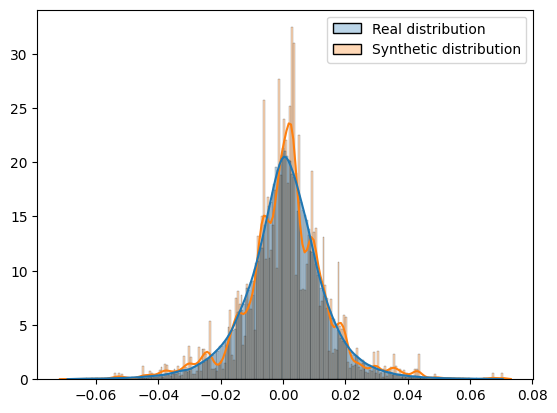

Model:  VAE-CONV1
Synth:  (111104,)
Reject outliers: 0.00%
Max before: 0.04, Max now: 0.04
Min before: -0.04, Min now: -0.04
Synth clean:  111104


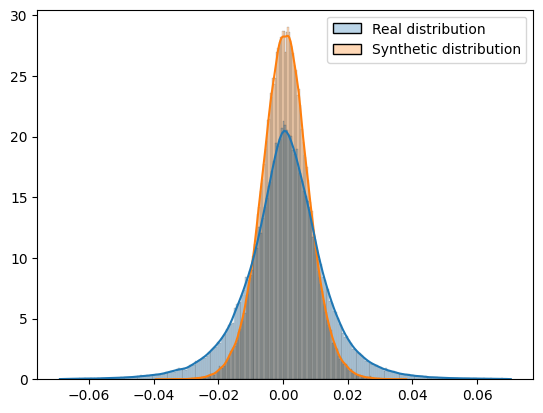

Model:  VAE-CONV3
Synth:  (111104,)
Reject outliers: 0.00%
Max before: 0.15, Max now: 0.15
Min before: -0.13, Min now: -0.13
Synth clean:  111104


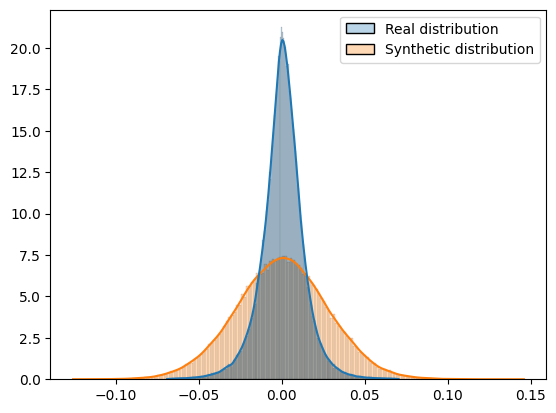

Model:  VAE-FD1
Synth:  (111104,)
Reject outliers: 0.01%
Max before: 0.11, Max now: 0.08
Min before: -0.09, Min now: -0.08
Synth clean:  111098


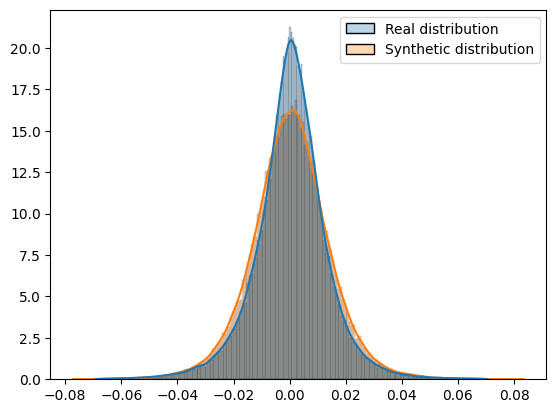

Model:  VAE-FD2
Synth:  (111104,)
Reject outliers: 0.01%
Max before: 0.04, Max now: 0.03
Min before: -0.04, Min now: -0.03
Synth clean:  111091


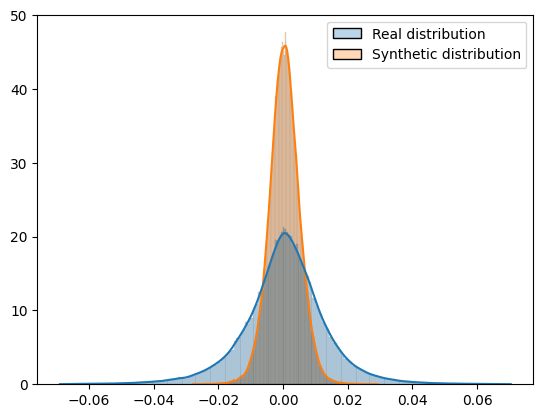

Model:  VQ-VAE-FD1
Synth:  (111104,)
Reject outliers: 0.00%
Max before: 0.06, Max now: 0.06
Min before: -0.04, Min now: -0.04
Synth clean:  111104


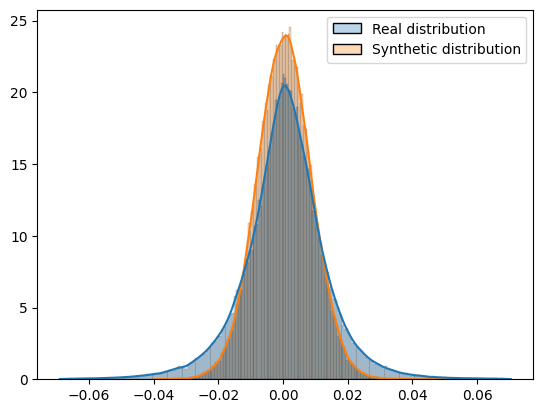

In [488]:

m=10
print("Real: ", real.shape[0])
real_clean = reject_outliers(real, m=m, verbose =True)
print("Real clean: ", real_clean.shape[0])
for model_name, synth in generated.items():
        model = model_name.strip()
        model = model.replace(' ', '-')
        synth_ft = synth.flatten()
        print('Model: ', model)       
        print("Synth: ", synth_ft.shape)
        synth_clean = reject_outliers(synth_ft, m=m, verbose =True)
        print("Synth clean: ", synth_clean.shape[0])
        plot_density(real_clean, synth_clean)
        

# Metrics 

In [664]:
def get_metrics(generated:dict, data_eval, sample,by_hist= False, w=None, correct_for_bias=True,bins='auto', density=True, outlier_rejection=True, m=10):
    results ={}
    for model_name, synth in generated.items():
        model = model_name.strip()
        model = model.replace(' ', '-')
        results[model] = {}
        print('Model: ', model)
        for i in range(4):
            results[model]['data'+str(i)] = {}
            real = data_eval[i].flatten()
            synth_flat =synth.flatten()
            kl, js = get_divergences(synth_flat, real, sample,by_hist= by_hist,w=w,correct_for_bias=correct_for_bias,bins=bins, density=density, outlier_rejection=outlier_rejection, m=m)
            ks = kstest(synth_flat, real, N=sample)
            wa = wasserstein_distance(synth_flat, real)
            results[model]['data'+str(i)]['Kullback-Leibler'] = kl
            results[model]['data'+str(i)]['Jensen-Shannon'] = js
            results[model]['data'+str(i)]['Kolmogorov-Smirnov'] = ks[0]
            results[model]['data'+str(i)]['KS-pvalue'] = True if ks[1] > 0.05 else False
            results[model]['data'+str(i)]['Wasserstein'] = wa 
    return pd.concat({k: pd.DataFrame(v) for k, v in results.items()}, axis=0)

sample =380 # sample calculator
outlier_rejection=True
m=10
bins='auto'
density=True
w=None
by_hist=False
correct_for_bias=False
metrics = get_metrics(generated.copy(), data_eval.copy(), sample,by_hist, w, correct_for_bias,bins, density, outlier_rejection, m)
display(metrics)

In [670]:
sample =380 # sample calculator
outlier_rejection=True
by_hist=False
correct_for_bias=False
metrics = get_metrics(generated.copy(), data_eval.copy(), 
                    sample,
                    by_hist= by_hist, 
                    correct_for_bias = correct_for_bias , 
                    outlier_rejection=outlier_rejection)
display(metrics)

Model:  VQ-VAE-CONV2
Model:  VAE-CONV1
Model:  VAE-CONV3
Model:  VAE-FD1
Model:  VAE-FD2
Model:  VQ-VAE-FD1


data0     data1     data2     data3
VQ-VAE-CONV2 Kullback-Leibler    0.000715  0.002128  0.000821  0.002395
             Jensen-Shannon      0.013431  0.022881  0.014396  0.024266
             Kolmogorov-Smirnov  0.029954  0.040899  0.033185  0.043905
             KS-pvalue              False     False     False     False
             Wasserstein         0.000745  0.000913  0.000545  0.000924
VAE-CONV1    Kullback-Leibler    0.210182  0.288442  0.212277  0.291791
             Jensen-Shannon       0.21026  0.242111  0.211231  0.243363
             Kolmogorov-Smirnov  0.096009  0.123083  0.106144  0.125531
             KS-pvalue              False     False     False     False
             Wasserstein          0.00399   0.00495  0.004402  0.005109
VAE-CONV3    Kullback-Leibler    0.344035  0.306284  0.332731  0.298565
             Jensen-Shannon      0.303345  0.285616  0.298525  0.282087
             Kolmogorov-Smirnov  0.194403  0.186942  0.200344  0.187203
             KS-pvalue              False     False     False     False
             Wasserstein         0.012387   0.01153  0.012067  0.011397
VAE-FD1      Kullback-Leibler     0.03114  0.021489  0.027384  0.019136
             Jensen-Shannon      0.089597  0.073688  0.084033  0.069528
             Kolmogorov-Smirnov  0.046263  0.032456  0.055885  0.035246
             KS-pvalue              False     False     False     False
             Wasserstein         0.001369  0.001016   0.00158  0.001173
VAE-FD2      Kullback-Leibler    0.423989  0.533584  0.423124  0.535958
             Jensen-Shannon      0.286884  0.316051  0.286603  0.316621
             Kolmogorov-Smirnov  0.193764  0.217544  0.200803  0.219974
             KS-pvalue              False     False     False     False
             Wasserstein         0.006108  0.007069  0.006519  0.007227
VQ-VAE-FD1   Kullback-Leibler    0.364588  0.434172  0.352233   0.42882
             Jensen-Shannon      0.280843  0.300896  0.276304  0.299067
             Kolmogorov-Smirnov  0.066532  0.092067  0.076109  0.094731
             KS-pvalue              False     False     False     False
             Wasserstein          0.00308  0.004028   0.00353  0.004195

In [673]:
metrics.to_csv(results_dir +'metrics.csv', index=False)

In [674]:
sample =1000 # sample calculator
outlier_rejection=True
by_hist=False
correct_for_bias=True
metrics = get_metrics(generated.copy(), data_eval.copy(), 
                    sample,
                    by_hist= by_hist, 
                    correct_for_bias = correct_for_bias , 
                    outlier_rejection=outlier_rejection)
display(metrics)

Model:  VQ-VAE-CONV2
Model:  VAE-CONV1
Model:  VAE-CONV3
Model:  VAE-FD1
Model:  VAE-FD2
Model:  VQ-VAE-FD1


data0     data1     data2     data3
VQ-VAE-CONV2 Kullback-Leibler    0.000715  0.002127  0.000821  0.002394
             Jensen-Shannon      0.013429  0.022878  0.014395  0.024264
             Kolmogorov-Smirnov  0.029954  0.040899  0.033185  0.043905
             KS-pvalue              False     False     False     False
             Wasserstein         0.000745  0.000913  0.000545  0.000924
VAE-CONV1    Kullback-Leibler    0.210103  0.288349  0.212197  0.291698
             Jensen-Shannon      0.210226  0.242077  0.211196  0.243329
             Kolmogorov-Smirnov  0.096009  0.123083  0.106144  0.125531
             KS-pvalue              False     False     False     False
             Wasserstein          0.00399   0.00495  0.004402  0.005109
VAE-CONV3    Kullback-Leibler    0.344024  0.306276   0.33272  0.298557
             Jensen-Shannon       0.30334  0.285613  0.298521  0.282083
             Kolmogorov-Smirnov  0.194403  0.186942  0.200344  0.187203
             KS-pvalue              False     False     False     False
             Wasserstein         0.012387   0.01153  0.012067  0.011397
VAE-FD1      Kullback-Leibler    0.031139  0.021489  0.027383  0.019136
             Jensen-Shannon      0.089595  0.073688  0.084032  0.069528
             Kolmogorov-Smirnov  0.046263  0.032456  0.055885  0.035246
             KS-pvalue              False     False     False     False
             Wasserstein         0.001369  0.001016   0.00158  0.001173
VAE-FD2      Kullback-Leibler    0.423688  0.533249  0.422819  0.535623
             Jensen-Shannon      0.286803  0.315974  0.286522  0.316544
             Kolmogorov-Smirnov  0.193764  0.217544  0.200803  0.219974
             KS-pvalue              False     False     False     False
             Wasserstein         0.006108  0.007069  0.006519  0.007227
VQ-VAE-FD1   Kullback-Leibler    0.364549  0.434117  0.352191  0.428764
             Jensen-Shannon       0.28083   0.30088   0.27629  0.299051
             Kolmogorov-Smirnov  0.066532  0.092067  0.076109  0.094731
             KS-pvalue              False     False     False     False
             Wasserstein          0.00308  0.004028   0.00353  0.004195

## Fitting Kernel

In [615]:
array = real.flatten()
m=10
array = reject_outliers(array, m=m)
bandwidth = 1.06 * array.std() * array.size ** (-1 / 5.)
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(array.reshape(-1, 1))
   


In [618]:
array.shape

(110790,)

In [619]:
X = np.linspace(np.min(array), np.max(array), sample)
probabilities = np.exp(kernel.score_samples(X.reshape(-1, 1)))



In [620]:
sum(probabilities)

2709.2731595281666

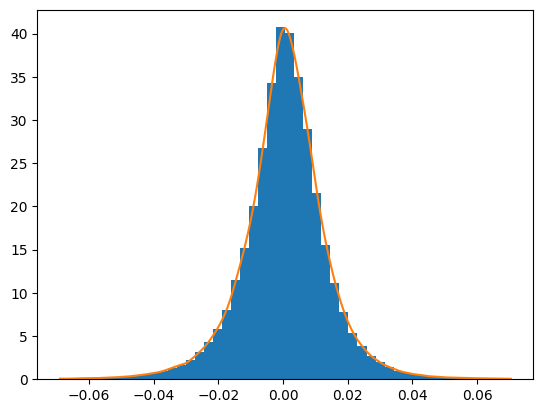

In [621]:
# plot the histogram and pdf
plt.hist(array, bins=50, density=True)
plt.plot(X, probabilities)
plt.show()

In [622]:
pdf = probabilities / np.sum(probabilities)
cdf = np.cumsum(pdf)

/var/folders/4t/55hr34s50pb0bz56v_nxv0j00000gn/T/ipykernel_61264/2912222184.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


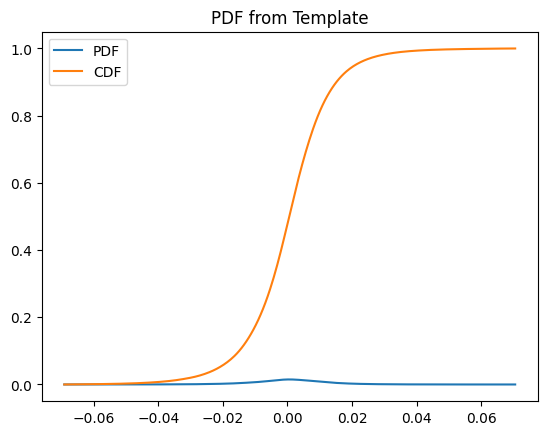

In [623]:
fig, ax = plt.subplots()
ax.set_title("PDF from Template")
# ax.hist(array, density=True, bins=100)

ax.plot(X, pdf, label='PDF')
ax.plot(X, cdf, label='CDF')
ax.legend()
fig.show()

In [624]:
pdf

array([2.64399362e-05, 2.55806081e-05, 2.48536012e-05, 2.43750558e-05,
       2.42151548e-05, 2.43980374e-05, 2.49116965e-05, 2.57240320e-05,
       2.67992521e-05, 2.81084099e-05, 2.96300630e-05, 3.13414908e-05,
       3.32056329e-05, 3.51613555e-05, 3.71233002e-05, 3.89929724e-05,
       4.06772480e-05, 4.21069311e-05, 4.32481407e-05, 4.41029220e-05,
       4.47005634e-05, 4.50850193e-05, 4.53047702e-05, 4.54092517e-05,
       4.54520330e-05, 4.54971851e-05, 4.56233185e-05, 4.59203416e-05,
       4.64769273e-05, 4.73610334e-05, 4.85999497e-05, 5.01683076e-05,
       5.19908711e-05, 5.39617198e-05, 5.59744554e-05, 5.79524771e-05,
       5.98672609e-05, 6.17372641e-05, 6.36089070e-05, 6.55297721e-05,
       6.75278364e-05, 6.96067252e-05, 7.17574996e-05, 7.39778862e-05,
       7.62859950e-05, 7.87197277e-05, 8.13223743e-05, 8.41232064e-05,
       8.71240914e-05, 9.02985612e-05, 9.36021686e-05, 9.69876164e-05,
       1.00417952e-04, 1.03874932e-04, 1.07363670e-04, 1.10915663e-04,
      

## Fitting histogram 

In [465]:
synth.shape

(111104,)

In [467]:
array = synth
density = True
bins='auto'
sample = 300
#Get histogram

hist, bin_edges =  np.histogram(array, bins=bins, density=density)
hist_norm = hist / np.sum(hist)
bin_edges_norm = bin_edges / np.sum(hist)
# if w:
#     print('Adding prior correction to histogram')
#     histogram_dist = rv_histogram((
#         np.histogram(array, bins=bins, density=density)[0] + w * np.ones(len(hist)),
#         bin_edges)
#         ,density=density)
# else:
histogram_dist = rv_histogram((hist, bin_edges),density=density)

#Generate arrays of pdf evaluations
X = np.linspace(np.min(array), np.max(array), sample)

rvs_array = np.array([histogram_dist.pdf(x) for x in X])


In [468]:
sum(rvs_array)

3996.1614437598264

In [472]:
pdf = rvs_array/sum(rvs_array)

In [476]:
cdf = np.cumsum(pdf)

/var/folders/4t/55hr34s50pb0bz56v_nxv0j00000gn/T/ipykernel_61264/2438387165.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


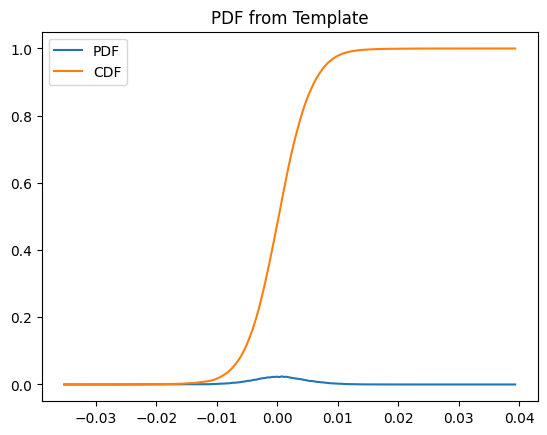

In [477]:

fig, ax = plt.subplots()
ax.set_title("PDF from Template")
# ax.hist(array, density=True, bins=100)

ax.plot(X, pdf, label='PDF')
ax.plot(X, cdf, label='CDF')
ax.legend()
fig.show()

## Jensen divergence

In [625]:
real.shape

(111104,)

In [626]:
synth = vaefd2.flatten()
real = data_eval[0].flatten()
sample =380 # sample calculator
outlier_rejection=True
m=10
bins='auto'
density=True
w=None
correct_for_bias=True

p = get_pdf(synth, sample=sample, by_hist= False,w=w, bins=bins, density=density, outlier_rejection=outlier_rejection, m=m)
q = get_pdf(real, sample=sample, by_hist= False, w=w, bins=bins, density=density, outlier_rejection=outlier_rejection, m=m)


In [627]:
q

array([2.64399362e-05, 2.55806081e-05, 2.48536012e-05, 2.43750558e-05,
       2.42151548e-05, 2.43980374e-05, 2.49116965e-05, 2.57240320e-05,
       2.67992521e-05, 2.81084099e-05, 2.96300630e-05, 3.13414908e-05,
       3.32056329e-05, 3.51613555e-05, 3.71233002e-05, 3.89929724e-05,
       4.06772480e-05, 4.21069311e-05, 4.32481407e-05, 4.41029220e-05,
       4.47005634e-05, 4.50850193e-05, 4.53047702e-05, 4.54092517e-05,
       4.54520330e-05, 4.54971851e-05, 4.56233185e-05, 4.59203416e-05,
       4.64769273e-05, 4.73610334e-05, 4.85999497e-05, 5.01683076e-05,
       5.19908711e-05, 5.39617198e-05, 5.59744554e-05, 5.79524771e-05,
       5.98672609e-05, 6.17372641e-05, 6.36089070e-05, 6.55297721e-05,
       6.75278364e-05, 6.96067252e-05, 7.17574996e-05, 7.39778862e-05,
       7.62859950e-05, 7.87197277e-05, 8.13223743e-05, 8.41232064e-05,
       8.71240914e-05, 9.02985612e-05, 9.36021686e-05, 9.69876164e-05,
       1.00417952e-04, 1.03874932e-04, 1.07363670e-04, 1.10915663e-04,
      

In [596]:
p

array([4.20668589e-06, 4.70711947e-06, 4.95551620e-06, 4.95667262e-06,
       4.76393045e-06, 4.45162454e-06, 4.08949070e-06, 3.73063601e-06,
       3.41126744e-06, 3.15256064e-06, 2.95901093e-06, 2.81738047e-06,
       2.70479141e-06, 2.60867022e-06, 2.55043775e-06, 2.59860277e-06,
       2.86034138e-06, 3.45118207e-06, 4.45325470e-06, 5.87792518e-06,
       7.64672282e-06, 9.59716847e-06, 1.15111739e-05, 1.31568591e-05,
       1.43323063e-05, 1.49019151e-05, 1.48201264e-05, 1.41401038e-05,
       1.30055572e-05, 1.16247146e-05, 1.02295259e-05, 9.02995514e-06,
       8.17780958e-06, 7.75195756e-06, 7.76673230e-06, 8.19330335e-06,
       8.97786788e-06, 1.00460368e-05, 1.12976140e-05, 1.26092413e-05,
       1.38609630e-05, 1.49834863e-05, 1.59995268e-05, 1.70265597e-05,
       1.82286359e-05, 1.97378531e-05, 2.15863112e-05, 2.36826284e-05,
       2.58408463e-05, 2.78437773e-05, 2.95124776e-05, 3.07590014e-05,
       3.16106466e-05, 3.22007864e-05, 3.27244023e-05, 3.33649010e-05,
      

In [628]:
print(sum(p>1), sum(q>1))
print(p.shape, q.shape)

0 0
(380,) (380,)


In [629]:
ps = pd.Series(p)
ps.value_counts()

0.000395    1
0.003646    1
0.003133    1
0.003187    1
0.003242    1
           ..
0.003188    1
0.003140    1
0.003093    1
0.003047    1
0.000336    1
Name: count, Length: 380, dtype: int64

In [630]:
p = np.array(p)
q = np.array(q)
# calculate m
m = (p + q) / 2
m.shape


(380,)

In [631]:
scipy.stats.entropy(p, q)

0.42398862392916703

In [632]:
scipy.stats.entropy(p, m)

0.07160083742482898

In [633]:
scipy.stats.entropy(q, m)

0.09300394195727545

In [634]:
np.sum(kl_div(p,q))

0.42398862392916703

In [635]:
np.sum(kl_div(p,m))

0.07160083742482903

In [636]:
np.sum(kl_div(q,m))

0.0930039419572754

In [637]:
np.sum(rel_entr(p,q))

0.42398862392916703

In [638]:
np.sum(rel_entr(p,m))

0.07160083742482898

In [639]:
np.sum(rel_entr(q,m))

0.09300394195727545

In [640]:
divergence = (np.sum(kl_div(p, m)) + np.sum(kl_div(q, m))) / 2
# compute the Jensen Shannon distance
distance = np.sqrt(divergence)
print(distance)

0.28688393069506735


In [641]:
jensenshannon(p,q)

0.28688393069506735

In [642]:
    if correct_for_bias:
        return np.sum(kl_div(synth_pdf, real_pdf)), js
    else:
        entropy = rel_entr(synth_pdf, real_pdf)
        return np.sum(entropy), js

SyntaxError: 'return' outside function (572813585.py, line 2)

In [643]:
# compute Jensen Shannon divergence
divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2
# compute the Jensen Shannon distance
distance = np.sqrt(divergence)

In [644]:
print('p shape: ', p.shape)
print('q shape: ', q.shape)

p shape:  (380,)
q shape:  (380,)


In [645]:
p[2]==0

False

In [646]:
p[p!=0].shape

(380,)

In [647]:
cond = p!=0
p = p[cond]
q = q[cond]
# calculate m
m = (p + q) / 2
print('p shape: ', p.shape)
print('q shape: ', q.shape)
print('m shape: ', m.shape)

p shape:  (380,)
q shape:  (380,)
m shape:  (380,)


In [648]:
sum(cond)

380

In [649]:
kl_divergence( p, q)

0.423988623929167

In [650]:
kl_divergence( p, m)

0.07160083742482899

In [651]:
kl_divergence( q, m)

0.09300394195727549

In [652]:
kl_divergence( p, p)

0.0

In [653]:
q

array([2.64399362e-05, 2.55806081e-05, 2.48536012e-05, 2.43750558e-05,
       2.42151548e-05, 2.43980374e-05, 2.49116965e-05, 2.57240320e-05,
       2.67992521e-05, 2.81084099e-05, 2.96300630e-05, 3.13414908e-05,
       3.32056329e-05, 3.51613555e-05, 3.71233002e-05, 3.89929724e-05,
       4.06772480e-05, 4.21069311e-05, 4.32481407e-05, 4.41029220e-05,
       4.47005634e-05, 4.50850193e-05, 4.53047702e-05, 4.54092517e-05,
       4.54520330e-05, 4.54971851e-05, 4.56233185e-05, 4.59203416e-05,
       4.64769273e-05, 4.73610334e-05, 4.85999497e-05, 5.01683076e-05,
       5.19908711e-05, 5.39617198e-05, 5.59744554e-05, 5.79524771e-05,
       5.98672609e-05, 6.17372641e-05, 6.36089070e-05, 6.55297721e-05,
       6.75278364e-05, 6.96067252e-05, 7.17574996e-05, 7.39778862e-05,
       7.62859950e-05, 7.87197277e-05, 8.13223743e-05, 8.41232064e-05,
       8.71240914e-05, 9.02985612e-05, 9.36021686e-05, 9.69876164e-05,
       1.00417952e-04, 1.03874932e-04, 1.07363670e-04, 1.10915663e-04,
      

In [654]:
m

array([0.00021054, 0.00021398, 0.00021751, 0.00022119, 0.00022504,
       0.00022908, 0.00023331, 0.00023771, 0.00024227, 0.00024698,
       0.00025184, 0.00025682, 0.00026193, 0.00026713, 0.00027239,
       0.00027766, 0.0002829 , 0.00028807, 0.00029318, 0.00029822,
       0.00030321, 0.00030818, 0.00031316, 0.00031818, 0.00032327,
       0.00032847, 0.00033381, 0.00033935, 0.00034512, 0.00035117,
       0.0003575 , 0.0003641 , 0.00037093, 0.00037793, 0.00038505,
       0.00039223, 0.00039947, 0.00040677, 0.00041415, 0.00042162,
       0.00042921, 0.00043692, 0.00044473, 0.00045266, 0.00046072,
       0.00046893, 0.00047732, 0.00048591, 0.00049471, 0.00050371,
       0.00051291, 0.00052228, 0.00053181, 0.0005415 , 0.00055137,
       0.00056142, 0.00057171, 0.00058227, 0.00059315, 0.00060442,
       0.00061609, 0.00062817, 0.00064064, 0.00065345, 0.00066655,
       0.00067989, 0.00069345, 0.00070726, 0.00072135, 0.0007358 ,
       0.00075066, 0.000766  , 0.00078185, 0.00079822, 0.00081

In [655]:
np.log(q/m)

array([-2.0748151 , -2.12406598, -2.16925403, -2.20544044, -2.22928378,
       -2.23956385, -2.23702401, -2.22363303, -2.20169577, -2.17325828,
       -2.13999388, -2.10344941, -2.06536371, -2.02779866, -1.99299042,
       -1.96301039, -1.93941081, -1.92300242, -1.91382535, -1.91129254,
       -1.9144322 , -1.92213339, -1.93330637, -1.94690711, -1.96183636,
       -1.97678665, -1.99015188, -2.00011121, -2.00493768, -2.00346377,
       -1.99551042, -1.98204507, -1.96494352, -1.94643504, -1.92846605,
       -1.91223029, -1.8980126 , -1.88535834, -1.87346362, -1.86160371,
       -1.84940844, -1.836878  , -1.82417908, -1.8113805 , -1.79830195,
       -1.7845595 , -1.76976376, -1.75373943, -1.7366369 , -1.71888665,
       -1.70104359, -1.68361516, -1.66694413, -1.65116087, -1.63617888,
       -1.62170578, -1.60726818, -1.59227265, -1.57612296, -1.55838241,
       -1.53893024, -1.51804286, -1.49635203, -1.47468468, -1.45384086,
       -1.43438903, -1.41654427, -1.4001592 , -1.38481772, -1.36

In [656]:
def kl_divergence( p, q):
    """ Compute KL divergence of two vectors, K(p || q)."""
    kl = 0
    for x in range(len(p)):
        if p[x] != 0.0 or p[x] != 0.0:
            # print('zero value')
            kl+=p[x] * np.log((p[x]) / (q[x]))
    return kl


def Jensen_Shannon_divergence(self, p, q):
    """ Returns the Jensen-Shannon divergence. """

    weight = 0.5
    average = zeros(len(p)) #Average
    for x in range(len(p)):
        average[x] = weight * p[x] + (1 - weight) * q[x]
        JSD = (weight * self.KL_divergence(array(p), average)) + ((1 - weight) * self.KL_divergence(array(q), average))
        return 1-(JSD/sqrt(2 * self.log2))